# What are the most frequently run reports?

>Questions being answered in this notebook.
>- [x] What is the most run report?

In [1]:
import pandas as pd

Loading active reports data.

In [2]:
active_reports = pd.read_csv("datasets/active_reports.csv", low_memory=False)

C:\Users\jefer\AppData\Local\Temp\ipykernel_9340\2173927402.py:1: DtypeWarning: Columns (10,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  active_reports = pd.read_csv("datasets/active_reports.csv")


In [3]:
active_reports.shape

(38326, 51)

In [4]:
# list(active_reports.columns)

In [5]:
interest_columns = ['REPORT_ID_DERIVED', 'Name']

Reports run frequency.

In [6]:
run_count = active_reports[interest_columns].value_counts(sort=True)

In [7]:
run_count.head()

REPORT_ID_DERIVED   Name                              
00O0b000006iNwdEAE  New Email By Team - w\o Sup filter    8816
00O0b000004kTazEAE  My Cases and Tasks                    6708
00O2R000004AmwmUAC  S&AS Reactive Queues                  2347
00O2R000003JCXaUAO  New Email By Team_HYD                 2293
00O6P000000ZMcoUAG  Wipro - VxRail Case Title Report      1392
dtype: int64

<AxesSubplot:ylabel='REPORT_ID_DERIVED,Name'>

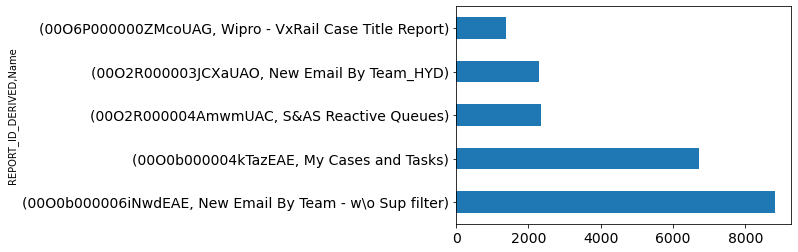

In [8]:
run_count.head(5).plot(kind='barh', fontsize=14)

In [9]:
run_count.mean()

111.73760932944606

In [10]:
run_count.median()

6.0

In [11]:
import matplotlib.pyplot as plt

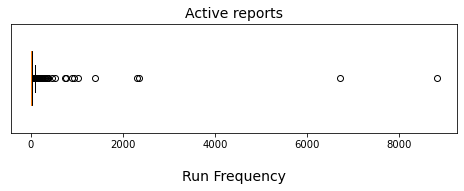

In [12]:
fig = plt.figure(figsize=(8,2))
plt.boxplot(run_count.values, vert=False, widths=[.5])
plt.title('Active reports', fontsize=14)
plt.xlabel('\nRun Frequency', fontsize=14)
plt.yticks([])
plt.show()

Removing the outlier report.

In [13]:
run_count.drop(run_count.index[0]).mean()

86.28654970760233

In [14]:
run_count.drop(run_count.index[0]).median()

6.0

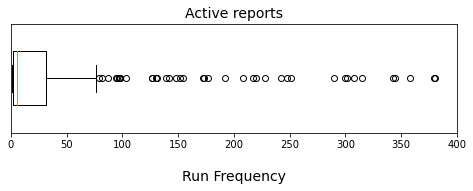

In [15]:
fig = plt.figure(figsize=(8,2))
plt.boxplot(run_count.drop(run_count.index[0]).values, vert=False, widths=[.5])
plt.title('Active reports', fontsize=14)
plt.xlabel('\nRun Frequency', fontsize=14)
plt.xlim(0, 400)
plt.yticks([])
plt.show()

## Analysis on PageView logs

Getting information about PageView of these most frequently run reports.

In [16]:
pageview_logs = pd.read_csv("data/Salesforce/ELF/LightningPageView/2022-06-04_LightningPageView.csv")

C:\Users\jefer\AppData\Local\Temp\ipykernel_9340\1616065154.py:1: DtypeWarning: Columns (5,11,13,17,18,19,20,22,24,28,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  pageview_logs = pd.read_csv("data/Salesforce/ELF/LightningPageView/2022-06-04_LightningPageView.csv")


In [17]:
pageview_logs.shape

(792349, 50)

In [18]:
# list(pageview_logs.columns)

Selecting the information we need.

On active reports.

In [19]:
active_reports_features = ['Name', 'REPORT_ID_DERIVED', 'SESSION_KEY',
                    'DB_TOTAL_TIME', 'DB_CPU_TIME', 'RUN_TIME',
                    'ROW_COUNT', 'AVERAGE_ROW_SIZE', 'NUMBER_COLUMNS']

In [20]:
active_reports = active_reports[active_reports_features]

In [21]:
run_count.index[0]

('00O0b000006iNwdEAE', 'New Email By Team - w\\o Sup filter')

In [22]:
active_reports = active_reports[active_reports.REPORT_ID_DERIVED == run_count.index[0][0]]

In [23]:
active_reports.shape

(8816, 9)

On Lightning PageView logs.

In [24]:
pageview_features = ['PAGE_ENTITY_ID', 
            'PAGE_ENTITY_TYPE', 'PAGE_CONTEXT', 'PAGE_APP_NAME', 'APP_NAME', 'PAGE_START_TIME', 'PAGE_URL', 
            'USER_ID_DERIVED', 'USER_TYPE', 'UI_EVENT_SOURCE',
            'DURATION', 'EFFECTIVE_PAGE_TIME', 'EFFECTIVE_PAGE_TIME_DEVIATION', 
            'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE', 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON', 
            'GRANDPARENT_UI_ELEMENT']

In [25]:
pageview_logs = pageview_logs[pageview_features]

In [26]:
pageview_logs.shape

(792349, 16)

In [27]:
pageview_logs.dropna(subset=['PAGE_URL'], inplace=True)

In [28]:
pageview_logs.shape

(789728, 16)

In [29]:
run_report_api_resource = "/lightning/r/"

def get_report_info_from_endpoint(page_url):
    if page_url.startswith(run_report_api_resource):
        uri = page_url.split(run_report_api_resource)
        if len(uri) >= 2:
            report_type, report_id_derived = uri[1].split("/")[:2]
            return report_type, report_id_derived

In [30]:
pageview_logs['REPORT_INFO_DERIVED'] = pageview_logs.PAGE_URL.apply(get_report_info_from_endpoint)

In [31]:
pageview_logs.dropna(subset=['REPORT_INFO_DERIVED'], inplace=True)

In [32]:
pageview_logs.shape

(542852, 17)

In [33]:
pageview_logs.REPORT_INFO_DERIVED.value_counts()

(Report, 00O0b000004kTazEAE)          5561
(Report, 00O0b000006iNwdEAE)          5502
(Report, 00O2R000004AmwmUAC)           935
(Report, 00O0b000005yLBGEA2)           860
(Report, 00O2R000003JCXaUAO)           779
                                      ... 
(WorkOrder, 0WO6P00000268UbWAI)          1
(Task, 00T6P00000I98X0UAJ)               1
(EmailMessage, 02s6P000009Yhw9QAC)       1
(Contact, 0036P000003s5GoQAI)            1
(Case, 5006P000005WVwMQAW)               1
Name: REPORT_INFO_DERIVED, Length: 129887, dtype: int64

In [34]:
pageview_logs['REPORT_TYPE_DERIVED'] = pageview_logs.REPORT_INFO_DERIVED.str[0]
pageview_logs['REPORT_ID_DERIVED'] = pageview_logs.REPORT_INFO_DERIVED.str[1]

In [35]:
pageview_logs.drop(columns=['REPORT_INFO_DERIVED'], inplace=True)

In [36]:
pageview_logs.shape

(542852, 18)

In [37]:
# pageview_logs.to_csv("datasets/pageview_logs.csv", index=False)

Cleaning data by removing inconsistent report IDs.

In [37]:
pageview_logs = pageview_logs[pageview_logs.REPORT_ID_DERIVED.str.len()==18]

In [38]:
pageview_logs.shape

(536605, 18)

Merging data.

In [39]:
active_reports.shape[0], pageview_logs.sample(100).shape[0]

(8816, 100)

In [40]:
# pd.merge(
#     left=active_reports, 
#     right=pageview_logs.sample(100), 
#     on='REPORT_ID_DERIVED').head()

In [41]:
most_run_pageview_logs = pd.merge(
    left=active_reports, 
    right=pageview_logs.sample(1000), 
    on='REPORT_ID_DERIVED')

In [42]:
most_run_pageview_logs.shape

(79344, 26)

## Most run active report

Checking for uniqueness.

In [43]:
most_run_pageview_logs.REPORT_ID_DERIVED.unique()

array(['00O0b000006iNwdEAE'], dtype=object)

Counting log events.

In [44]:
most_run_pageview_logs.shape[0]

79344

Problematic reports regarding time.

In [45]:
most_run_pageview_logs = most_run_pageview_logs[most_run_pageview_logs['EFFECTIVE_PAGE_TIME'].isna()]

In [46]:
most_run_pageview_logs.shape[0]

35264

In [47]:
for feat in pageview_features:
    print(f"\n{feat.upper()}")
    print(most_run_pageview_logs[feat].value_counts(sort=True).head())


PAGE_ENTITY_ID
Series([], Name: PAGE_ENTITY_ID, dtype: int64)

PAGE_ENTITY_TYPE
Report    35264
Name: PAGE_ENTITY_TYPE, dtype: int64

PAGE_CONTEXT
reports:reportBase    35264
Name: PAGE_CONTEXT, dtype: int64

PAGE_APP_NAME
LightningService    35264
Name: PAGE_APP_NAME, dtype: int64

APP_NAME
one:one    35264
Name: APP_NAME, dtype: int64

PAGE_START_TIME
1654358053208    8816
1654328885502    8816
1654354494837    8816
1654322790398    8816
Name: PAGE_START_TIME, dtype: int64

PAGE_URL
/lightning/r/Report/00O0b000006iNwdEAE/view?queryScope=userFolders    35264
Name: PAGE_URL, dtype: int64

USER_ID_DERIVED
0056P000000xVd8QAE    8816
0051P000003jYi5QAE    8816
0050b000004KH7hAAG    8816
0050b000004K3fXAAS    8816
Name: USER_ID_DERIVED, dtype: int64

USER_TYPE
Standard    35264
Name: USER_TYPE, dtype: int64

UI_EVENT_SOURCE
Series([], Name: UI_EVENT_SOURCE, dtype: int64)

DURATION
2300.0     8816
1198.0     8816
12929.0    8816
14630.0    8816
Name: DURATION, dtype: int64

EFFECTIVE_PAGE_

In [63]:
# mean duration in seconds
most_run_pageview_logs.DURATION.mean() / 1000

7.76425

In [61]:
import numpy as np

# min and max duration in seconds
np.array([most_run_pageview_logs.DURATION.min(), most_run_pageview_logs.DURATION.max()]) / 1000

array([ 1.198, 14.63 ])

In [54]:
most_run_pageview_logs[most_run_pageview_logs.DURATION >= 60000]

,Name,REPORT_ID_DERIVED,SESSION_KEY,DB_TOTAL_TIME,DB_CPU_TIME,RUN_TIME,ROW_COUNT,AVERAGE_ROW_SIZE,NUMBER_COLUMNS,PAGE_ENTITY_ID,...,USER_ID_DERIVED,USER_TYPE,UI_EVENT_SOURCE,DURATION,EFFECTIVE_PAGE_TIME,EFFECTIVE_PAGE_TIME_DEVIATION,EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE,EFFECTIVE_PAGE_TIME_DEVIATION_REASON,GRANDPARENT_UI_ELEMENT,REPORT_TYPE_DERIVED


In [48]:
import datetime as dt 

In [49]:
dt.timedelta(milliseconds=1654318905531)

datetime.timedelta(days=19147, seconds=18105, microseconds=531000)

In [50]:
dt.timedelta(milliseconds=566)

datetime.timedelta(microseconds=566000)

In [51]:
dt.timedelta(milliseconds=(1654318905531 + 566))

datetime.timedelta(days=19147, seconds=18106, microseconds=97000)